# Bank Marketing Dataset
Predicting Term Deposit Suscriptions

## Importing libs

In [5]:
# Data
import pandas as pd

# Export
import pickle

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Modeling
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

## Loading data

In [6]:
df = pd.read_csv("../data/bank.csv")
df.sample(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
5934,41,technician,married,tertiary,no,63,no,no,cellular,25,aug,36,3,-1,0,unknown,no
5334,56,unemployed,married,secondary,no,660,yes,no,unknown,6,jun,72,3,-1,0,unknown,no
4069,63,retired,single,tertiary,no,791,no,no,cellular,21,oct,212,2,-1,0,unknown,yes


In [7]:
dep_mapping = {"yes": 1, "no": 0}

# Convert the column to category and map the values
df["deposit"] = df["deposit"].astype("category").map(dep_mapping)

df = df.drop(labels = ["default", "contact", "day", "month", "pdays", "previous", "loan", "poutcome", "poutcome"], axis=1)

df.sample(3)

,age,job,marital,education,balance,housing,duration,campaign,deposit
454,34,blue-collar,single,primary,-109,yes,860,4,1
10833,38,management,married,tertiary,-558,yes,533,1,0
9412,45,admin.,single,secondary,375,no,10,1,0


# Check data

In [8]:
print("Shape")
print(df.shape)

print("\nTypes")
print(df.dtypes)

Shape
(11162, 9)

Types
age             int64
job            object
marital        object
education      object
balance         int64
housing        object
duration        int64
campaign        int64
deposit      category
dtype: object


### Check missings

In [16]:
pd.DataFrame(df.isnull().sum()).T

,age,job,marital,education,balance,housing,duration,campaign,deposit
0,0,0,0,0,0,0,0,0,0


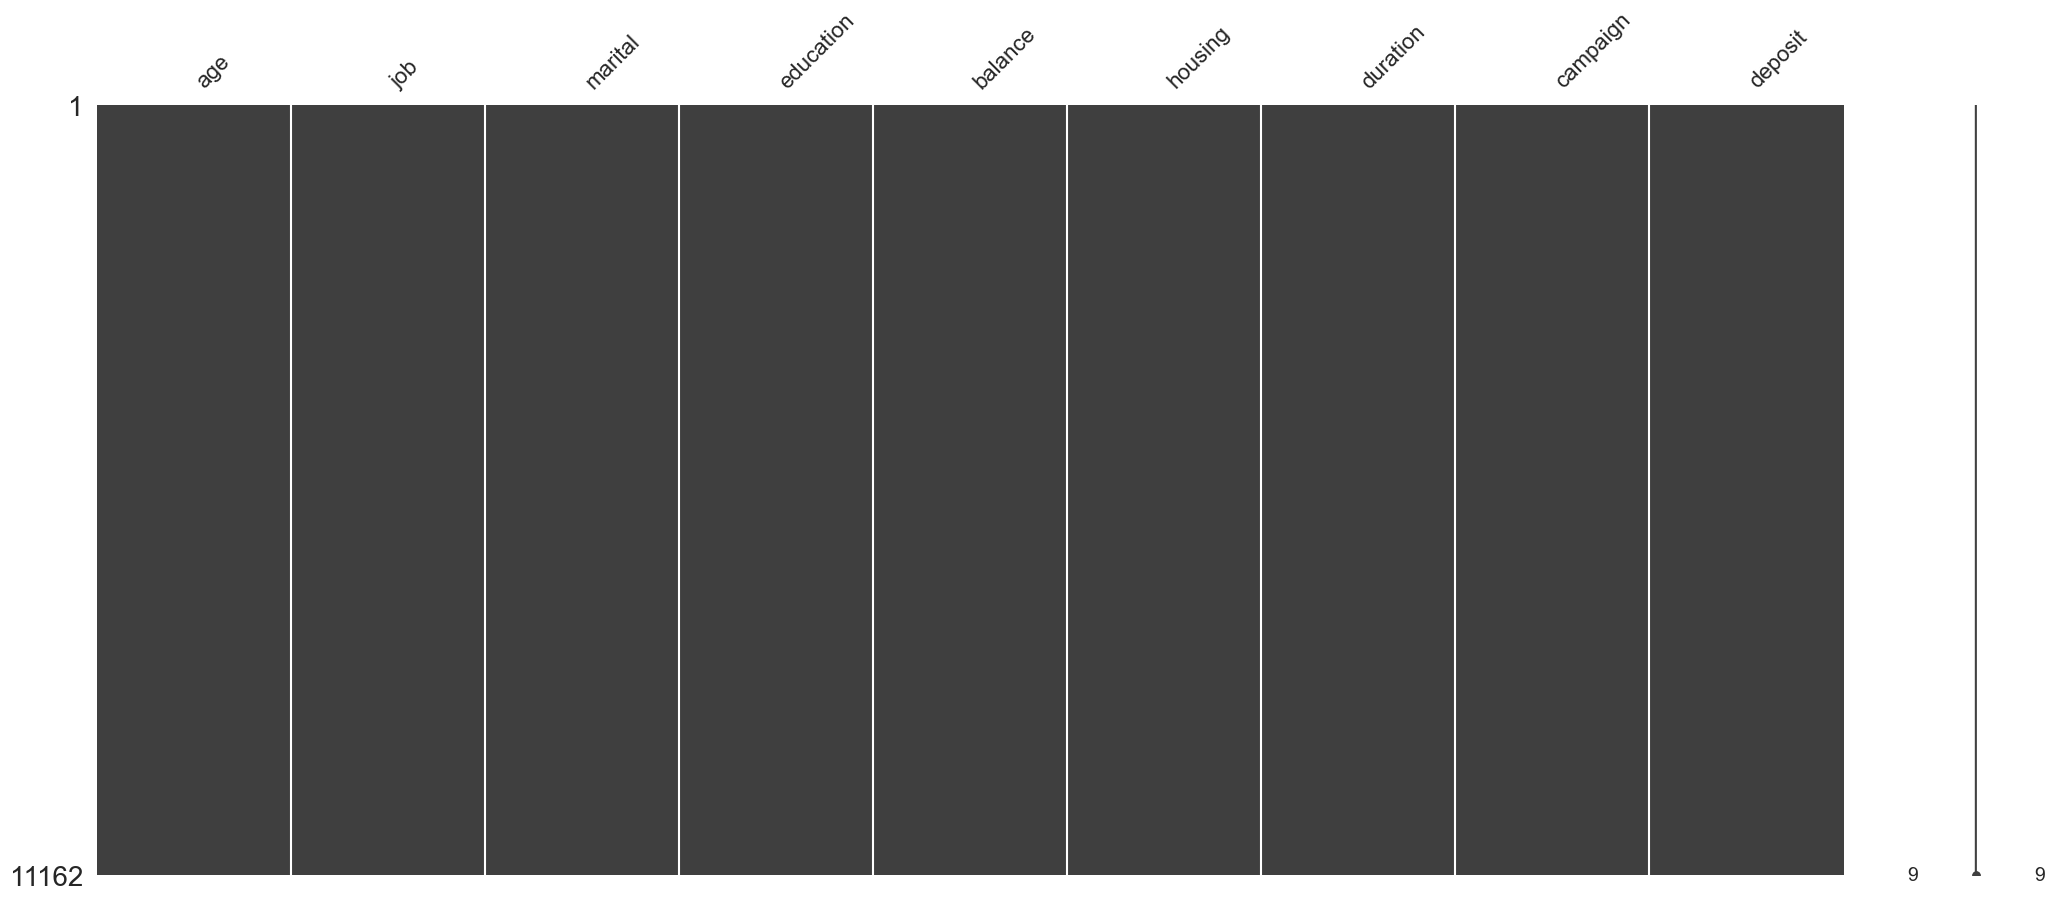

In [17]:
msno.matrix(df)
plt.show()

In [18]:
cat_cols = ["job", "marital", "education", "housing"]
num_cols = ["age", "balance", "duration", "campaign"]

In [9]:
df.describe()

,age,balance,duration,campaign
count,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,371.993818,2.508421
std,11.913369,3225.413326,347.128386,2.722077
min,18.000000,-6847.000000,2.000000,1.000000
25%,32.000000,122.000000,138.000000,1.000000
50%,39.000000,550.000000,255.000000,2.000000
75%,49.000000,1708.000000,496.000000,3.000000
max,95.000000,81204.000000,3881.000000,63.000000


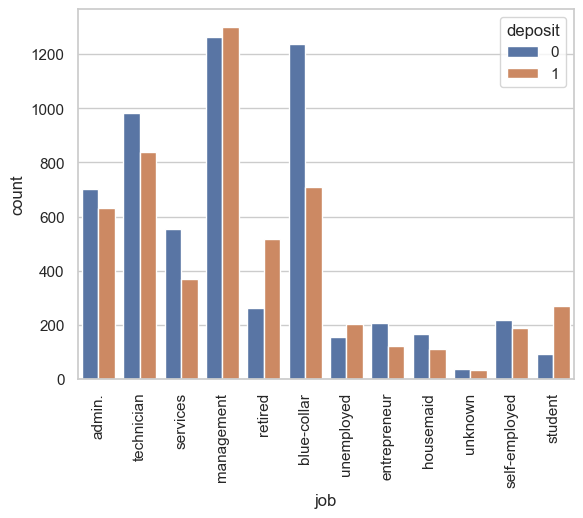

In [10]:
sns.set(style="whitegrid")
g = sns.countplot(data=df, x="job", hue="deposit")
g.set_xticklabels(g.get_xticklabels(), rotation=90);

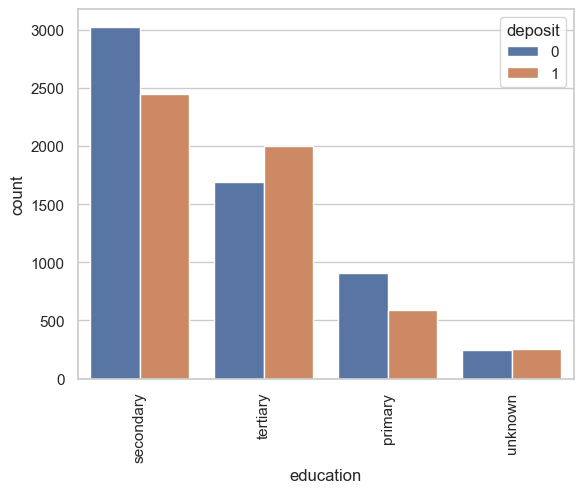

In [11]:
sns.set(style="whitegrid")
g = sns.countplot(data=df, x="education", hue="deposit")
g.set_xticklabels(g.get_xticklabels(), rotation=90);

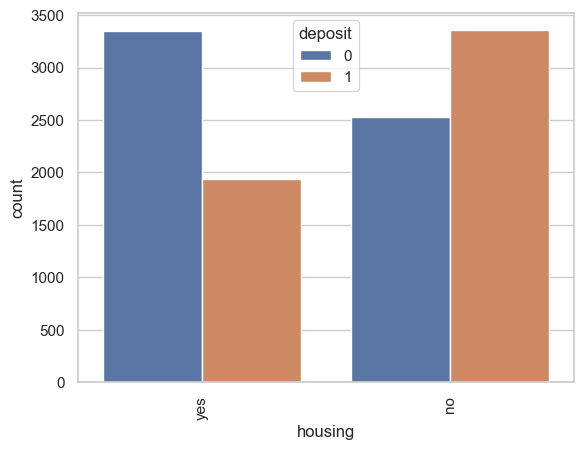

In [12]:
sns.set(style="whitegrid")
g = sns.countplot(data=df, x="housing", hue="deposit")
g.set_xticklabels(g.get_xticklabels(), rotation=90);

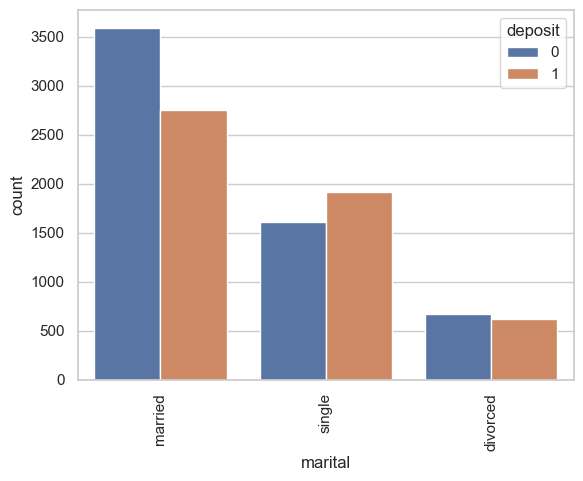

In [13]:
sns.set(style="whitegrid")
g = sns.countplot(data=df, x="marital", hue="deposit")
g.set_xticklabels(g.get_xticklabels(), rotation=90);

/Users/rodrigo/opt/anaconda3/envs/mlops/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


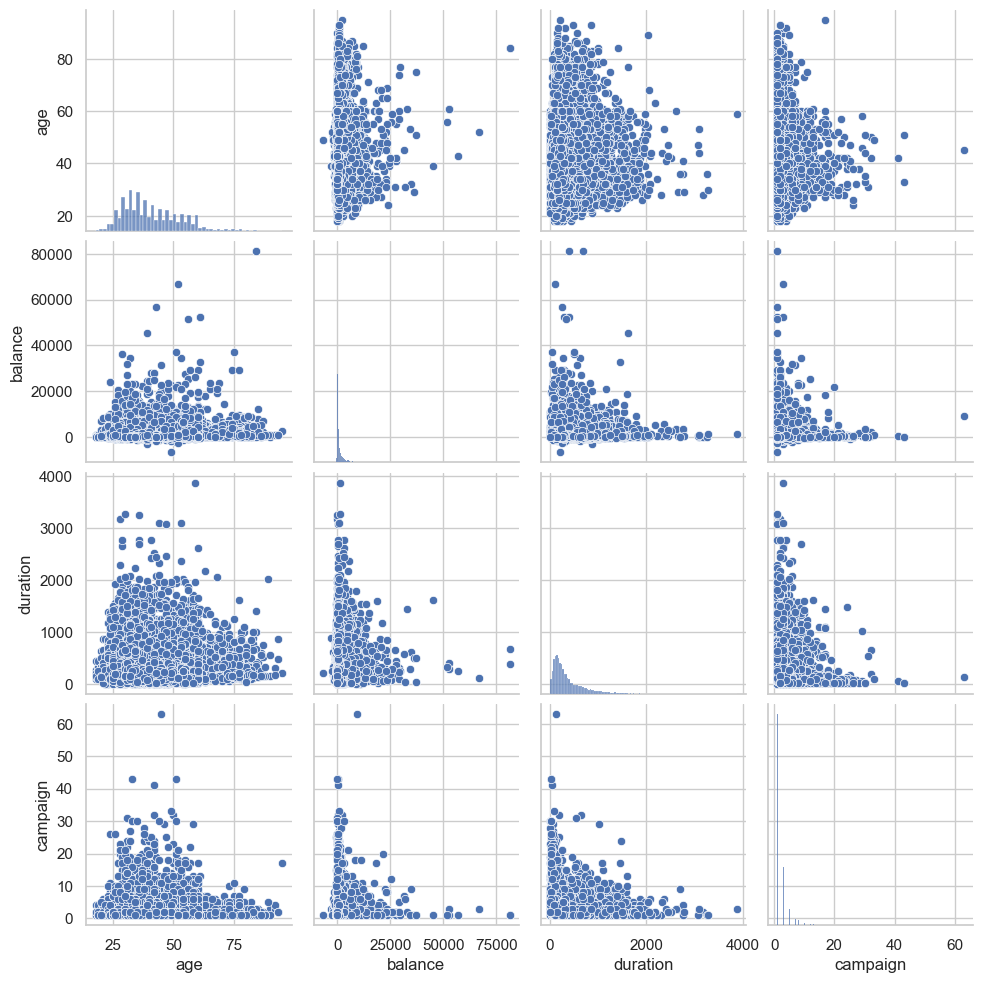

In [14]:
sns.pairplot(df)

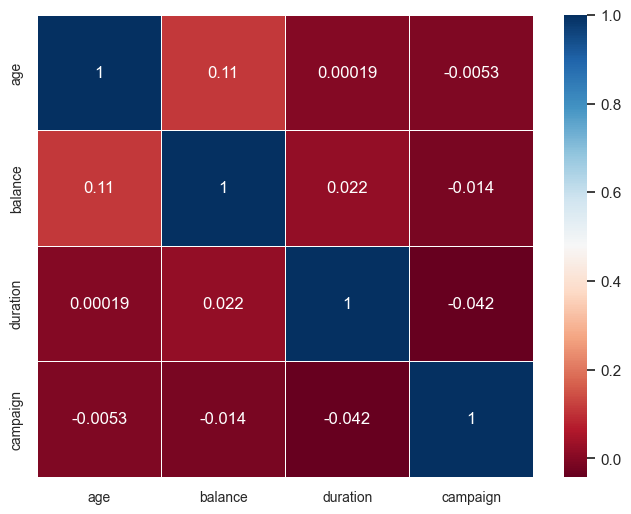

In [19]:
def correlation_matrix(df, cols):
     fig = plt.gcf()
     fig.set_size_inches(8, 6)
     plt.xticks(fontsize=10)
     plt.yticks(fontsize=10)
     fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={"size": 12}, linecolor="w", cmap="RdBu")
     plt.show(block=True)

correlation_matrix(df, num_cols)

## Model

split data into features and target 

In [20]:
X = df.drop("deposit", axis=1)
y = df["deposit"]

and make train test split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1912)

In [22]:
one_hot_enc = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore", drop="first"),
    cat_cols),
    remainder="passthrough")

X_train = one_hot_enc.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=one_hot_enc.get_feature_names_out())

X_train.head(2)

,onehotencoder__job_blue-collar,onehotencoder__job_entrepreneur,onehotencoder__job_housemaid,onehotencoder__job_management,onehotencoder__job_retired,onehotencoder__job_self-employed,onehotencoder__job_services,onehotencoder__job_student,onehotencoder__job_technician,onehotencoder__job_unemployed,...,onehotencoder__marital_married,onehotencoder__marital_single,onehotencoder__education_secondary,onehotencoder__education_tertiary,onehotencoder__education_unknown,onehotencoder__housing_yes,remainder__age,remainder__balance,remainder__duration,remainder__campaign
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,43.0,-410.0,189.0,1.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,42.0,558.0,186.0,2.0


In [23]:
X_test = pd.DataFrame(one_hot_enc.transform(X_test), columns=one_hot_enc.get_feature_names_out())
X_test.head(2)

,onehotencoder__job_blue-collar,onehotencoder__job_entrepreneur,onehotencoder__job_housemaid,onehotencoder__job_management,onehotencoder__job_retired,onehotencoder__job_self-employed,onehotencoder__job_services,onehotencoder__job_student,onehotencoder__job_technician,onehotencoder__job_unemployed,...,onehotencoder__marital_married,onehotencoder__marital_single,onehotencoder__education_secondary,onehotencoder__education_tertiary,onehotencoder__education_unknown,onehotencoder__housing_yes,remainder__age,remainder__balance,remainder__duration,remainder__campaign
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,50.0,388.0,701.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,35.0,-54.0,70.0,2.0


In [24]:
model = LGBMClassifier()
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 3746, number of negative: 4067
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000962 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 7813, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.479457 -> initscore=-0.082217
[LightGBM] [Info] Start training from score -0.082217


LGBMClassifier()

## Evaluation

Specificity: 0.783499446290144
Confusion Matrix:


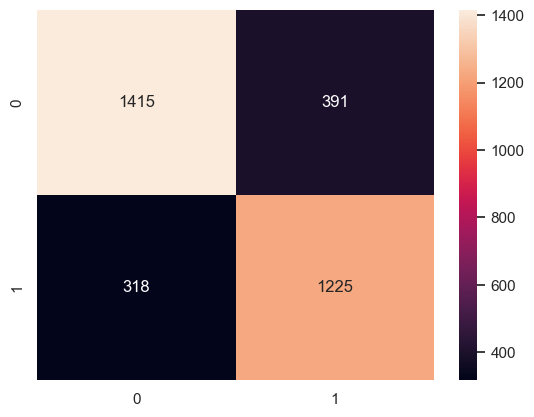

In [25]:
y_pred = model.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn+fp)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="g");

print(f"Specificity: {specificity}")
print("Confusion Matrix:")

In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.78      0.80      1806
           1       0.76      0.79      0.78      1543

    accuracy                           0.79      3349
   macro avg       0.79      0.79      0.79      3349
weighted avg       0.79      0.79      0.79      3349



## Save model

In [27]:
# Specify the file path where you want to save the pickle file
file_path = "model.pkl"

# Save the model as a pickle file
with open(file_path, "wb") as f:
    pickle.dump(model, f)

file_path = "ohe.pkl"

# Save the OneHotEncoder as a pickle file
with open(file_path, "wb") as f:
    pickle.dump(one_hot_enc, f)

# References

- https://www.kaggle.com/datasets/janiobachmann/bank-marketing-dataset
- https://www.kaggle.com/code/enesztrk/bank-credit-analysis-classification